In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
from src.dataset.panoptic import Panoptic
from src.box_clustering import multiViewHumanBoxesClustering
from src.multiview_3d import *
from src.bundle_adjustment import bundleAdjustmentWrapper
from src.plot_functions import *
from src.evaluate import *
import time


dataset = Panoptic('./data/panoptic_160422_ultimatum1')
# dataset = Panoptic('./data/panoptic_160422_haggling1')

# frame_id = 4962
frame_id = 5128

# --- Visualize 2D pose
# plotSingleFrameMultiView2dJoints(
#     dataset, frame_id, plot_joint_id=False, save_plot=True)

# --- Step 1: crop bounding box
boxcrop_dir = dataset.getSingleFrameMultiViewBoxes(
    frame_id, box_joints_margin=(1.2, 1.25), box_size_thold=(20, 20),
    box_ios_thold=0.3, joints_inside_img_ratio=0.5, box_inside_img_ratio=0.6,
    verbose=True, resize=(128, 256), replace_old=False)

box_reid_feat = dataset.getFrameReIDFeat(
    frame_id, num_prev_frames=10, trking_method='person_id',
    trk_feat_method='max_with_sign_voting')

# # --- Step 2: cluster boxes using re-ID feature
boxfile_clusters = multiViewHumanBoxesClustering(
    box_reid_feat, n_persons=4, size_min=2, size_max=dataset.num_cam,
    method='kmeans_ssc', n_init=50, compare_clust_methods=False)

# --- Step 3: generate 2D-2D point correpondences
pts_corresp_dict, n_persons = dataset.genPtsCorrepFromBoxClus(
    boxfile_clusters, frame_id=frame_id, verbose=True, noise_sz=5)

wrld_cam_id = 0
# Pts_prev = dataset.getFrameEst3DPose(frame_id-1, wrld_cam_id)

# # --- Step 4: solve 3D human pose
Pts, BA_input, wrld_cam_name = solveMultiView3DHumanPoses(
    pts_corresp_dict, dataset.cam_params_dict, n_persons, Pts_prev=None,
    wrld_cam_id=wrld_cam_id, verbose=False, M2_angle_thold=15)



Perform clustering:
[0.02 seconds] "kmeans_ssc" | "cosine" | 4 clusters.

Method         Distance       Purity    RI        ARI       F_Score   
kmeans_ssc     cosine         1.000     1.000     1.000     1.000     


Get 2D-2D correspondences:
Get pt correspondences of person 5.
Get pt correspondences of person 6.
Get pt correspondences of person 7.
Get pt correspondences of person 8.

Saved to:
"./data/panoptic_160422_ultimatum1/box_crop/frame00005128/box_gen_corresp_dict.pkl".




Bundle adjustment:
[[ 0.50497474 -0.28079198]
 [-0.09563229  0.05639257]
 [-0.34248055  0.15088455]
 [-2.39396613  1.54506116]
 [ 0.80501294 -0.50073747]]
[ 0.50497474 -0.28079198 -0.09563229  0.05639257 -0.34248055  0.15088455
 -2.39396613  1.54506116  0.80501294 -0.50073747]
[[ 0.50497474 -0.28079198]
 [-0.09563229  0.05639257]
 [-0.34248055  0.15088455]
 [-2.39396613  1.54506116]
 [ 0.80501294 -0.50073747]]
[ 0.50497474 -0.28079198 -0.09563229  0.05639257 -0.34248055  0.15088455
 -2.39396613  1.54506116  0.80501294 -0.50073747]
[[ 0.50497474 -0.28079198]
 [-0.09563229  0.05639257]
 [-0.34248055  0.15088455]
 [-2.3939381   1.54506126]
 [ 0.80501294 -0.50073747]]
[ 0.50497474 -0.28079198 -0.09563229  0.05639257 -0.34248055  0.15088455
 -2.3939381   1.54506126  0.80501294 -0.50073747]
[[ 0.50497474 -0.28079198]
 [-0.09563229  0.05639257]
 [-0.34248055  0.15088455]
 [-2.39396613  1.54506116]
 [ 0.80501291 -0.50076713]]
[ 0.50497474 -0.28079198 -0.09563229  0.05639257 -0.34248055  0.150

(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

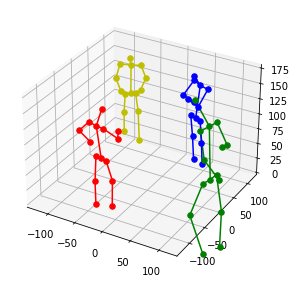

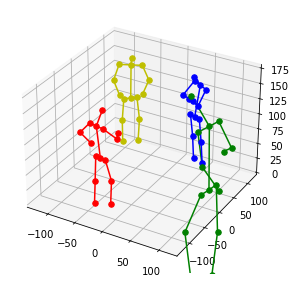

In [2]:
# --- Step 5: bundle adjustement
Pts_BA, M2s_BA = bundleAdjustmentWrapper(
    BA_input, Pts_prev=None, max_iter=100, fix_cam_pose=False, verbose=True,
    save_dir=os.path.join(dataset.boxcrop_dir,'frame'+str(frame_id).zfill(8)),
    wrld_cam_id=wrld_cam_id)

rot_x = 0
rot_z = 180
xlim, ylim, zlim = (-133.4, 125.6), (-134.1, 127.3), (0., 177.)

Pts_world = dataset.convertToWrldCoord(Pts, wrld_cam_name)
_, Pts_world, _, _ = dataset.alignEstAndGTCoords(frame_id, Pts, wrld_cam_name)
# Pts_world = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_world.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_world, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)

Pts_w_gt, Pts_w_est, _, scale = dataset.alignEstAndGTCoords(frame_id, Pts_BA, wrld_cam_name)
# Pts_w_est = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_w_est.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_w_est, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)


In [3]:
from src import basic_3d_operations as b3dops

M10 = np.array(dataset.cam_params_dict[wrld_cam_name]['M'])
M01 = b3dops.invertExtrinMat(M10)

cameras = sorted(dataset.cam_params_dict.keys())
M2s_gt = []
for camera in cameras:
    M20 = np.array(dataset.cam_params_dict[camera]['M'])
    M21 = b3dops.transmitExtrinMats(M20, M01)
    M2s_gt.append(np.array(M21))
# print(M2s_gt)
M2s_gt.pop(wrld_cam_id)

M2s_est = M2s_BA.copy()
# M2s_est.insert(wrld_cam_id, np.array([[1., 0., 0., 0.],
#                                       [0., 1., 0., 0.],
#                                       [0., 0., 1., 0.]]))

angle_mean, dist_mean = [], []
for i in range(len(M2s_gt)):
    R2_gt = M2s_gt[i][:, :3]
    R2_est = M2s_est[i][:, :3]
    angle = b3dops.angleBtwnRotatMats(R2_gt, R2_est)
    print(angle)
    angle_mean.append(angle)
    
    t2_gt = M2s_gt[i][:, 3].squeeze()
    t2_est = M2s_est[i][:, 3].squeeze()
    dist = np.linalg.norm(t2_gt - t2_est * scale)
    dist_mean.append(dist)

print('R error: {}, T error: {}'.format(np.mean(angle_mean), np.mean(dist_mean)))
# print(Pts_w_gt)

0.24007150098866237
0.20852181495736485
0.33920971480691553
0.5292261904268681
R error: 0.32925730529495273, T error: 3.2423594703047707


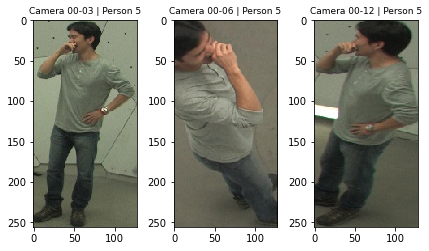

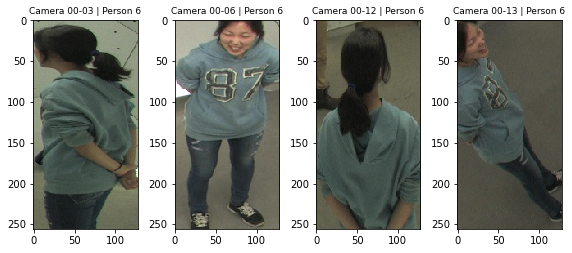

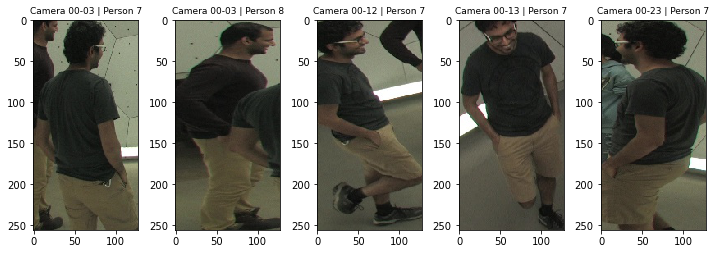

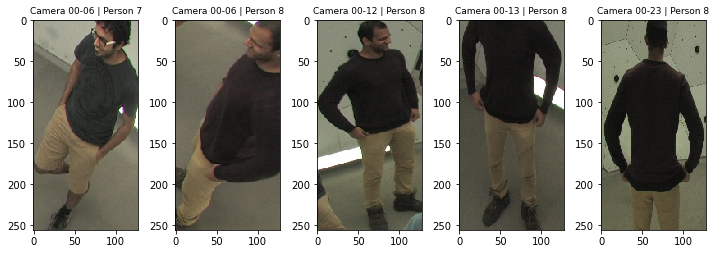

In [7]:
# plotSingleFrameMultiView2dJoints(dataset, frame_id, plot_joint_id=False, save_plot=True)

person_ids = sorted(list(boxfile_clusters_0.keys()))
for person_id in person_ids:
    plotMultiViewBoxClusters(boxfile_clusters_0[person_id])

(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

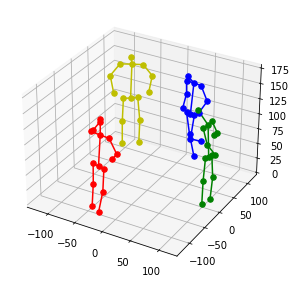

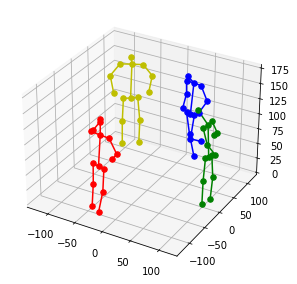

In [27]:
rot_x = 0
rot_z = 180
xlim, ylim, zlim = (-133.4, 125.6), (-134.1, 127.3), (0., 177.)

Pts_world = dataset.convertToWrldCoord(Pts, wrld_cam_name)
_, Pts_world, _ = dataset.alignEstAndGTCoords(frame_id, Pts, wrld_cam_name)
Pts_world = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_world.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_world, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)

Pts_w_gt, Pts_w_est, _ = dataset.alignEstAndGTCoords(frame_id, Pts_BA, wrld_cam_name)
Pts_w_est = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_w_est.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_w_est, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)

In [6]:
def countNumCorrectPeople(Joints_3d_gt, Joints_3d_est, body_edges, n_person,
                          alpha=0.5, parts_correct_ratio=0.6):
    '''
    Count number of correctly reconstructed people.
    '''
    n_joints = len(Joints_3d_gt) // n_person
    n_correct = 0
    for i in range(n_person):
        start, end = i * n_joints, (i + 1) * n_joints
        body3d_gt = Joints_3d_gt[start:end]
        body3d_est = Joints_3d_est[start:end]
        total_count, correct_count = countCorrectEstBodyParts(
            body3d_gt, body3d_est, body_edges, alpha=alpha)
        print(correct_count, total_count)
        
        if float(correct_count) / float(total_count) >= parts_correct_ratio:
            n_correct += 1
    return n_person, n_correct


alpha = 0.5
parts_correct_ratio = 0.6

_, Pts_w_est_0, _ = dataset.alignEstAndGTCoords(frame_id, Pts, wrld_cam_name)
Pts_w_gt, Pts_w_est, Pts_by_person = dataset.alignEstAndGTCoords(frame_id, Pts_BA, wrld_cam_name)

# --- print
print_info, format_list = 'Frame {} | alpha = {} | thold = {}', [frame_id, alpha]
total_count, correct_count = countNumCorrectPeople(
    Pts_w_gt, Pts_w_est_0, dataset.body_edges,
    n_persons, alpha=alpha, parts_correct_ratio=parts_correct_ratio)
total_count, correct_count_BA = countNumCorrectPeople(
    Pts_w_gt, Pts_w_est, dataset.body_edges,
    n_persons, alpha=alpha, parts_correct_ratio=parts_correct_ratio)
print('Frame {} | alpha = {} | thold = {} | total people: {}, correct: {}, correct_BA: {}'.format(
    frame_id, alpha, parts_correct_ratio, total_count, correct_count, correct_count_BA))

14 14
9 14
14 14
14 14
14 14
9 14
14 14
14 14
Frame 5026 | alpha = 0.5 | thold = 0.6 | total people: 4, correct: 4, correct_BA: 4


/home/yan/auto_3d_human_pose/src/plot_functions.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

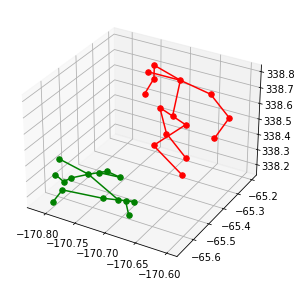

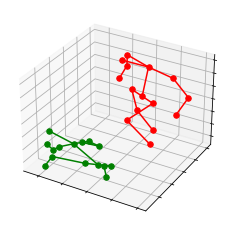

In [2]:
rot_x = 0
rot_z = 180

result_dir = os.path.join(dataset.data_dir.replace('data', 'result'), str(frame_id).zfill(8))

# Visualization
Pts_world = dataset.convertToWrldCoord(Pts, wrld_cam_name)
Pts_world = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_world.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_world, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                     save_img_file=None)

Pts_BA_world = dataset.convertToWrldCoord(Pts_BA, wrld_cam_name)
Pts_BA_world = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_BA_world.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_BA_world, n_persons, dataset.body_edges, plt_jnt_id=False,
                      save_img_file=os.path.join(result_dir, '3dpose_ours.png'), show_label=False)